In [14]:
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from itertools import product

import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Load and Preprocess the Dataset

In [ ]:
train_df = pd.read_csv('train.csv')

numeric_columns = train_df.select_dtypes(include=['float64', 'int64']).columns
train_df[numeric_columns] = train_df[numeric_columns].fillna(train_df[numeric_columns].mean())

categorical_columns = train_df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    train_df[col].fillna(train_df[col].mode()[0], inplace=True)

train_df.drop_duplicates(inplace=True)

label_encoder = LabelEncoder()
train_df['species'] = label_encoder.fit_transform(train_df['species'])
label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

print("\nLabel Mapping:", label_mapping)

def load_images(image_folder, image_names, target_size=(128, 128)):
    images = []
    for name in image_names:
        img_path = os.path.join(image_folder, name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return np.array(images)

image_folder = 'images'
train_images = load_images(image_folder, train_df['id'].astype(str) + '.jpg')
train_images = train_images / 255.0

train_df.drop('id', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    train_images, train_df['species'].values, test_size=0.2, stratify=train_df['species'].values, random_state=42
)

num_classes = len(np.unique(y_train))


Label Mapping: {0: 'Acer_Capillipes', 1: 'Acer_Circinatum', 2: 'Acer_Mono', 3: 'Acer_Opalus', 4: 'Acer_Palmatum', 5: 'Acer_Pictum', 6: 'Acer_Platanoids', 7: 'Acer_Rubrum', 8: 'Acer_Rufinerve', 9: 'Acer_Saccharinum', 10: 'Alnus_Cordata', 11: 'Alnus_Maximowiczii', 12: 'Alnus_Rubra', 13: 'Alnus_Sieboldiana', 14: 'Alnus_Viridis', 15: 'Arundinaria_Simonii', 16: 'Betula_Austrosinensis', 17: 'Betula_Pendula', 18: 'Callicarpa_Bodinieri', 19: 'Castanea_Sativa', 20: 'Celtis_Koraiensis', 21: 'Cercis_Siliquastrum', 22: 'Cornus_Chinensis', 23: 'Cornus_Controversa', 24: 'Cornus_Macrophylla', 25: 'Cotinus_Coggygria', 26: 'Crataegus_Monogyna', 27: 'Cytisus_Battandieri', 28: 'Eucalyptus_Glaucescens', 29: 'Eucalyptus_Neglecta', 30: 'Eucalyptus_Urnigera', 31: 'Fagus_Sylvatica', 32: 'Ginkgo_Biloba', 33: 'Ilex_Aquifolium', 34: 'Ilex_Cornuta', 35: 'Liquidambar_Styraciflua', 36: 'Liriodendron_Tulipifera', 37: 'Lithocarpus_Cleistocarpus', 38: 'Lithocarpus_Edulis', 39: 'Magnolia_Heptapeta', 40: 'Magnolia_Sali

### Display Sample Images

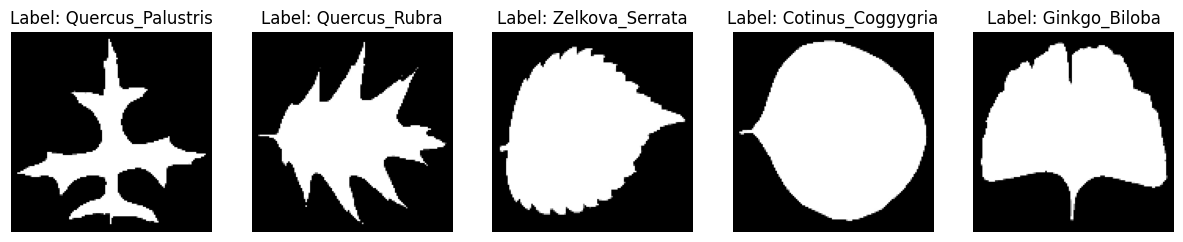

In [16]:
num_samples = 5
plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {label_mapping[y_train[i]]}")
    plt.axis('off')
plt.show()

### Building and Training Neural Network

In [17]:
def step_decay(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.9

param_grid = {
    'num_layers': [2],
    'dropout_rate': [0.5 , 0.3],
    'optimizer_name': ['adam', 'sgd', 'rmsprop'],
    'weight_decay': [0.01 , 0.001],
    'initial_lr': [0.001 , 0.0001],
    'lr_scheduler': [
        None,
        'step_decay',
        'ReduceLROnPlateau'
    ],
}

param_combinations = list(product(
    param_grid['num_layers'],
    param_grid['dropout_rate'],
    param_grid['optimizer_name'],
    param_grid['weight_decay'],
    param_grid['initial_lr'],
    param_grid['lr_scheduler']
))

best_accuracy = 0
best_params = None
best_model_path = "leaf_classification_cnn_model.keras"
results = []

for params in param_combinations:
    num_layers, dropout_rate, optimizer_name, weight_decay, initial_lr, lr_scheduler = params
    print(f"\nTraining with params: {params}")
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3),
                     kernel_regularizer=l2(weight_decay)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for _ in range(num_layers - 1):
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(weight_decay))) 
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y_train.max() + 1, activation='softmax', kernel_regularizer=l2(weight_decay)))

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=initial_lr)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=initial_lr, momentum=0.9)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=initial_lr, decay=1e-6, rho=0.9)
    else:
        raise ValueError("Invalid optimizer. Choose 'adam', 'sgd', or 'rmsprop'.")

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    callbacks = []
    if lr_scheduler == 'step_decay':
        callbacks.append(LearningRateScheduler(step_decay))
    elif lr_scheduler == 'ReduceLROnPlateau':
        callbacks.append(ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6))

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=20,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    _, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    results.append((params, test_accuracy))

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_params = params
        model.save(best_model_path)
        print(f"New best model saved to {best_model_path}")

print("\nBest Parameters:")
print(best_params)
print(f"Best Accuracy: {best_accuracy * 100:.2f}%")
print(f"Best model saved to: {best_model_path}")

print("\nAll Results:")
for params, accuracy in results:
    print(f"Params: {params}, Accuracy: {accuracy * 100:.2f}%")



Training with params: (2, 0.5, 'adam', 0.01, 0.001, None)
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 240ms/step - accuracy: 0.0039 - loss: 8.3422 - val_accuracy: 0.0202 - val_loss: 6.4602
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.0134 - loss: 6.2266 - val_accuracy: 0.0101 - val_loss: 5.6951
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.0186 - loss: 5.5894 - val_accuracy: 0.0051 - val_loss: 5.3373
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.0231 - loss: 5.2651 - val_accuracy: 0.0202 - val_loss: 5.1196
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - accuracy: 0.0241 - loss: 5.0746 - val_accuracy: 0.0253 - val_loss: 4.8923
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 244ms/step - accuracy: 0.0453 - loss: 4.8147 - val_accuracy: 0.0808 - val_loss: 4.6084
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - accuracy: 0.0869 - loss: 4.5069 - val_accuracy: 0.1869 - val_loss: 4.1884
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 229m

### Evaluation

In [74]:
model_path = 'leaf_classification_cnn_model.keras'

model = tf.keras.models.load_model(model_path)
print(f"\nModel loaded from {model_path}")

print("\nEvaluating on Training Set:")
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

print("\nEvaluating on Test Set:")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_classes))


Model loaded from leaf_classification_cnn_model.keras

Evaluating on Training Set:
Training Accuracy: 99.62%

Evaluating on Test Set:
Test Accuracy: 55.05%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.20      0.50      0.29         2
           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         2
           3       1.00      0.50      0.67         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       0.33      0.50      0.40         2
           7       0.40      1.00      0.57         2
           8       1.00      1.00      1.00         2
           9       0.50      1.00      0.67         2
          10       0.33      0.50      0.40         2
          11       0.50      0.50      0.50         2
          12       0.00      0.00      0.00         2
          13 

### Plotting Training History

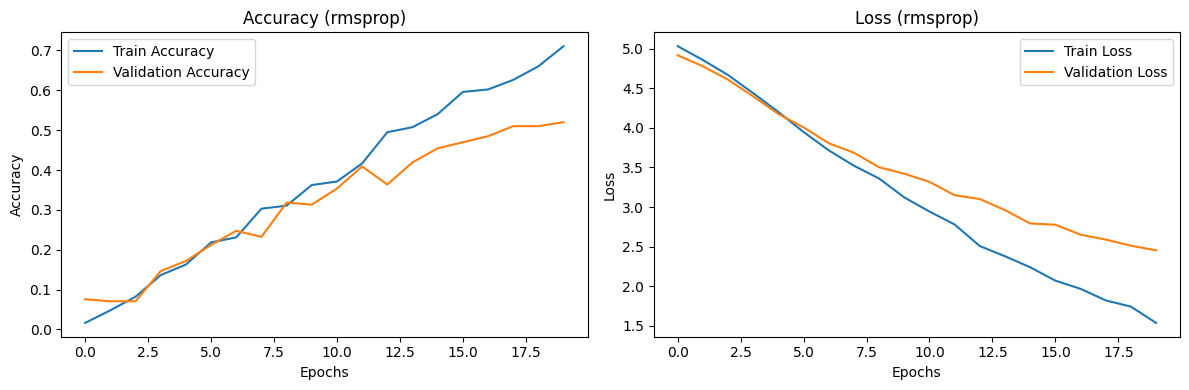

In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Accuracy ({optimizer_name})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Loss ({optimizer_name})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Bar Graph

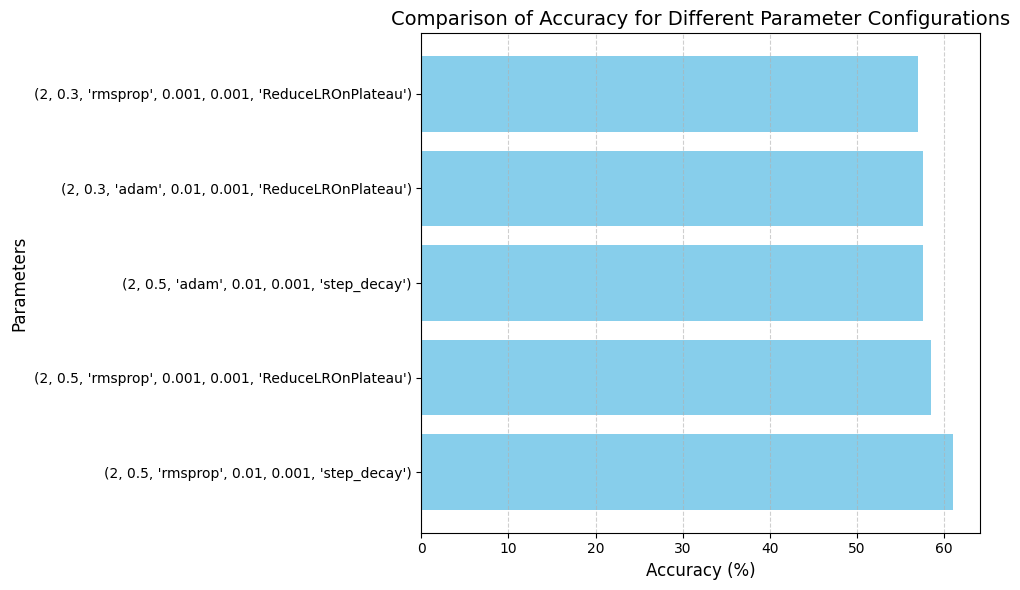

In [32]:
import matplotlib.pyplot as plt

# Data
params = [
    "(2, 0.5, 'rmsprop', 0.01, 0.001, 'step_decay')",
    "(2, 0.5, 'rmsprop', 0.001, 0.001, 'ReduceLROnPlateau')",
    "(2, 0.5, 'adam', 0.01, 0.001, 'step_decay')",
    "(2, 0.3, 'adam', 0.01, 0.001, 'ReduceLROnPlateau')",
    "(2, 0.3, 'rmsprop', 0.001, 0.001, 'ReduceLROnPlateau')"
]
accuracies = [61.11, 58.59, 57.58, 57.58, 57.07]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(params, accuracies, color='skyblue')
plt.xlabel('Accuracy (%)', fontsize=12)
plt.ylabel('Parameters', fontsize=12)
plt.title('Comparison of Accuracy for Different Parameter Configurations', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

# Display
plt.show()


### Classify new images

In [75]:
model = tf.keras.models.load_model(model_path)
print(f"\nModel loaded from {model_path}")

def preprocess_image(img_path, target_size=(128, 128)):
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, target_size)
        img = img / 255.0 
        return img
    return None

images = []
valid_image_names = []

test_images_folder = 'test_images'
test_images = ['1.jpg', '2.jpg', '3.jpg','40.jpg' , '11.jpg' , '71.jpg' , '88.jpg']
for name in test_images:
    img_path = os.path.join(test_images_folder, name)
    img = preprocess_image(img_path)
    if img is not None:
        images.append(img)
        valid_image_names.append(name)
    else:
        print(f"Warning: Could not load image {name}. Skipping.")

if not images:
    print("No valid images to classify.")
else:
    images = np.array(images)
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    for i, name in enumerate(valid_image_names):
        print(f"Image: {name} -> Predicted Label: {label_mapping[predicted_classes[i]]}")


Model loaded from leaf_classification_cnn_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Image: 1.jpg -> Predicted Label: Acer_Opalus
Image: 2.jpg -> Predicted Label: Pterocarya_Stenoptera
Image: 3.jpg -> Predicted Label: Quercus_Hartwissiana
Image: 40.jpg -> Predicted Label: Quercus_Phillyraeoides
Image: 11.jpg -> Predicted Label: Quercus_Rubra
Image: 71.jpg -> Predicted Label: Cornus_Controversa
Image: 88.jpg -> Predicted Label: Cercis_Siliquastrum
